# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\andre\AppData\Local\Temp\ipykernel_14348\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


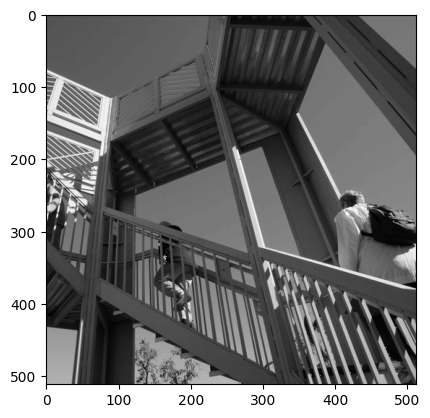

In [3]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

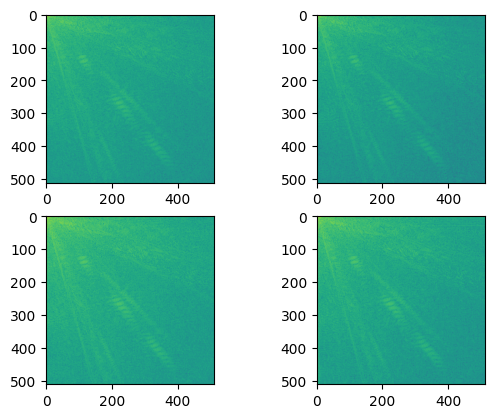

In [4]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

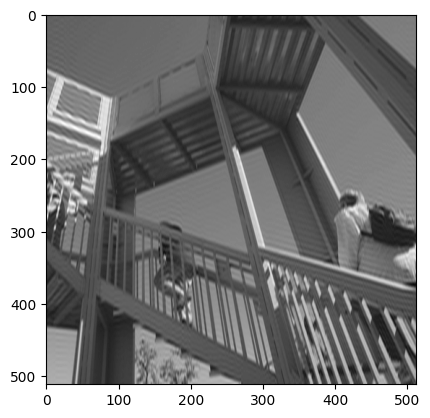

In [5]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

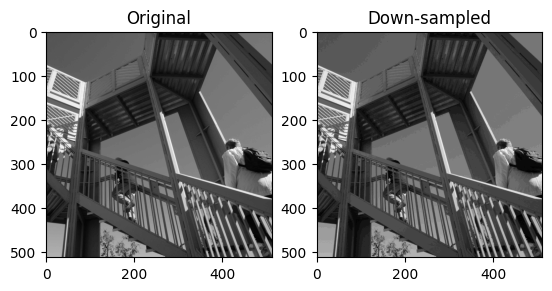

In [6]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

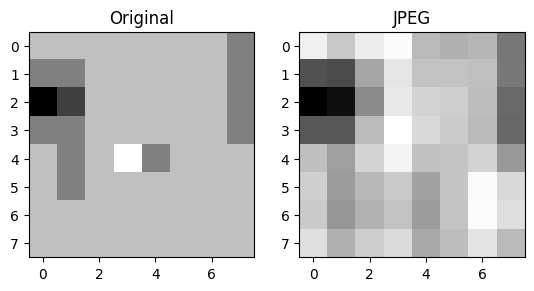

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [7]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

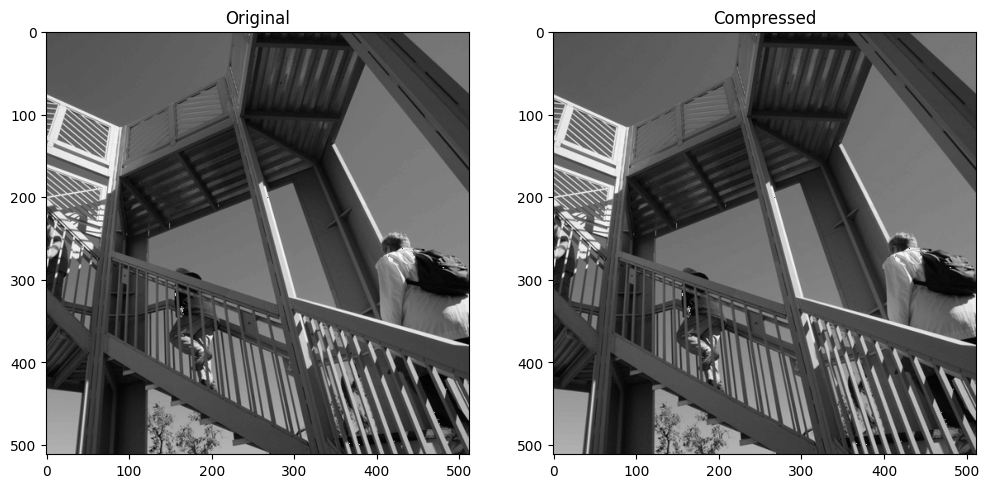

Mean pixel difference: 0.7247848510742188
Max pixel difference: 6


In [8]:
def process_blocks(image, block_size=8):
    pad_height = block_size - (image.shape[0] % block_size)
    pad_width = block_size - (image.shape[1] % block_size)
    if pad_height != block_size:
        image = np.pad(image, ((0, pad_height), (0, 0)), mode='constant')
    if pad_width != block_size:
        image = np.pad(image, ((0, 0), (0, pad_width)), mode='constant')
    
    compressed_image = np.zeros_like(image)

    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size]

            block = dctn(block)
            block = np.round(block / Q_jpeg) * Q_jpeg

            block = idctn(block)

            compressed_image[i:i+block_size, j:j+block_size] = block

    return compressed_image

X_compressed = process_blocks(X)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(X, cmap=plt.cm.gray)
axs[0].set_title('Original')

axs[1].imshow(X_compressed, cmap=plt.cm.gray)
axs[1].set_title('Compressed')

plt.show()

difference = X.astype(int) - X_compressed.astype(int)  
absolute_difference = np.abs(difference)

mean_difference = np.mean(absolute_difference)
max_difference = np.max(absolute_difference)
print(f"Mean pixel difference: {mean_difference}")
print(f"Max pixel difference: {max_difference}")

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

C:\Users\andre\AppData\Local\Temp\ipykernel_14348\3927232300.py:69: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  image = misc.face()


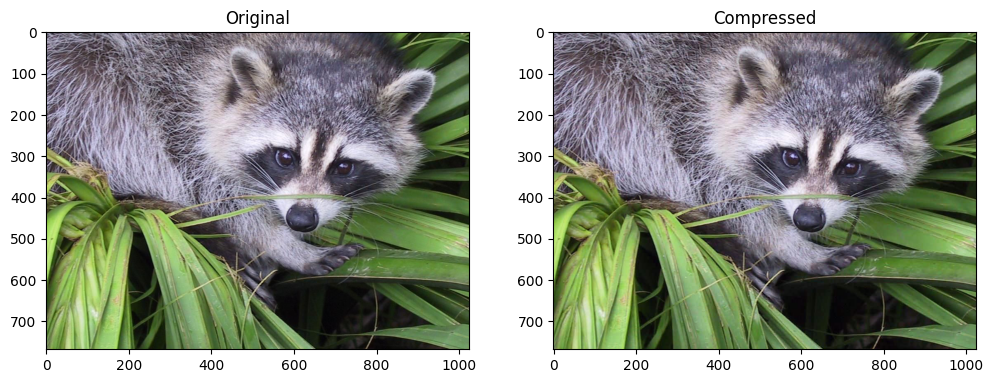

Mean pixel difference: 3.0019433763292103
Max pixel difference: 38


In [9]:
Q_jpeg_CbCr = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

def rgb2ycbcr(rgb_image):
    transform_matrix = np.array([
        [0.299, 0.587, 0.114],
        [-0.168736, -0.331264, 0.5],
        [0.5, -0.418688, -0.081312]
    ])
    shift = np.array([0, 128, 128])

    ycbcr_image = np.dot(rgb_image, transform_matrix.T) + shift

    return ycbcr_image

def ycbcr2rgb(ycbcr_image):
    transform_matrix = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344136, -0.714136],
        [1.0, 1.772, 0.0]
    ])
    shift = np.array([0, -128, -128])

    rgb_image = np.dot(ycbcr_image + shift, transform_matrix.T)

    return rgb_image

def compress_channel(channel, quant_matrix, block_size=8):
    pad_height = (block_size - channel.shape[0] % block_size) % block_size
    pad_width = (block_size - channel.shape[1] % block_size) % block_size
    channel_padded = np.pad(channel, ((0, pad_height), (0, pad_width)), mode='constant')

    compressed_channel = np.zeros_like(channel_padded)

    for i in range(0, channel_padded.shape[0], block_size):
        for j in range(0, channel_padded.shape[1], block_size):
            block = channel_padded[i:i+block_size, j:j+block_size]
            block = dctn(block, norm='ortho')
            block = np.round(block / quant_matrix) * quant_matrix
            block = idctn(block, norm='ortho')
            compressed_channel[i:i+block_size, j:j+block_size] = block

    compressed_channel = np.clip(compressed_channel, 0, 255)
    return compressed_channel

def process_blocks_color(image, quant_matrix, quant_matrix_cbcr, block_size=8):
    ycbcr_image = rgb2ycbcr(image)

    compressed_Y = compress_channel(ycbcr_image[:, :, 0], quant_matrix, block_size)
    compressed_Cb = compress_channel(ycbcr_image[:, :, 1], quant_matrix_cbcr, block_size)
    compressed_Cr = compress_channel(ycbcr_image[:, :, 2], quant_matrix_cbcr, block_size)

    compressed_ycbcr = np.stack((compressed_Y, compressed_Cb, compressed_Cr), axis=-1)

    compressed_rgb = ycbcr2rgb(compressed_ycbcr)

    compressed_rgb = np.clip(compressed_rgb, 0, 255).astype(np.uint8)

    return compressed_rgb

image = misc.face()

image_compressed = process_blocks_color(image, Q_jpeg, Q_jpeg_CbCr)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title('Original')

axs[1].imshow(image_compressed)
axs[1].set_title('Compressed')
plt.show()

difference = image.astype(int) - image_compressed.astype(int)  
absolute_difference = np.abs(difference)

mean_difference = np.mean(absolute_difference)
max_difference = np.max(absolute_difference)
print(f"Mean pixel difference: {mean_difference}")
print(f"Max pixel difference: {max_difference}")



3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

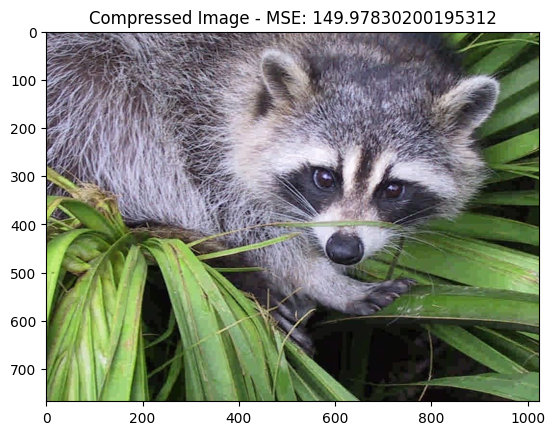

In [13]:
def mse(original, compressed):
    m, n, _ = original.shape
    mse = np.sum((original - compressed) ** 2) / (m * n)
    return mse

def compress_to_mse_threshold(original, quant_matrix, quant_matrix_cbcr, mse_threshold, block_size=8):
    quant_matrix = np.array(quant_matrix, dtype=float)
    compressed = process_blocks_color(original, quant_matrix, quant_matrix_cbcr, block_size)
    current_mse = mse(original, compressed)
    
    if current_mse > mse_threshold:
        return compressed, current_mse
    
    while current_mse < mse_threshold:
        quant_matrix *= np.sqrt(mse_threshold/current_mse)
        compressed = process_blocks_color(original, quant_matrix, quant_matrix_cbcr, block_size)
        new_mse = mse(original, compressed)

        if new_mse > mse_threshold:
            break
        
        current_mse = new_mse

    return compressed, current_mse

mse_threshold = 150
compressed_image, achieved_mse = compress_to_mse_threshold(image, Q_jpeg, Q_jpeg_CbCr, mse_threshold)

plt.imshow(compressed_image)
plt.title(f'Compressed Image - MSE: {achieved_mse}')
plt.show()

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

In [16]:
def compress_video(video_path, output_path, quant_matrix, quant_matrix_cbcr, block_size=8):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_number = 0    
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_number += 1
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            compressed_frame = process_blocks_color(frame_rgb, quant_matrix, quant_matrix_cbcr, block_size)

            print(f"Compressed Frame {frame_number}/{total_frames}: dtype={compressed_frame.dtype}, min={compressed_frame.min()}, max={compressed_frame.max()}")

            compressed_frame = cv2.cvtColor(compressed_frame, cv2.COLOR_RGB2BGR)

            out.write(compressed_frame)

            cv2.imshow('Compressed Frame', compressed_frame)
            cv2.waitKey(1)  
        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print("Compression complete. Video saved to", output_path)

compress_video('cat2.mp4', 'cat2_compresat.mp4', Q_jpeg, Q_jpeg_CbCr)


Compressed Frame 1/282: dtype=uint8, min=0, max=229
Compressed Frame 2/282: dtype=uint8, min=0, max=229
Compressed Frame 3/282: dtype=uint8, min=0, max=231
Compressed Frame 4/282: dtype=uint8, min=0, max=231
Compressed Frame 5/282: dtype=uint8, min=0, max=230
Compressed Frame 6/282: dtype=uint8, min=0, max=233
Compressed Frame 7/282: dtype=uint8, min=0, max=229
Compressed Frame 8/282: dtype=uint8, min=0, max=231
Compressed Frame 9/282: dtype=uint8, min=0, max=233
Compressed Frame 10/282: dtype=uint8, min=0, max=231
Compressed Frame 11/282: dtype=uint8, min=0, max=233
Compressed Frame 12/282: dtype=uint8, min=0, max=233
Compressed Frame 13/282: dtype=uint8, min=0, max=233
Compressed Frame 14/282: dtype=uint8, min=0, max=233
Compressed Frame 15/282: dtype=uint8, min=0, max=233
Compressed Frame 16/282: dtype=uint8, min=0, max=235
Compressed Frame 17/282: dtype=uint8, min=0, max=236
Compressed Frame 18/282: dtype=uint8, min=0, max=234
Compressed Frame 19/282: dtype=uint8, min=0, max=234
Co